In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

### Questão 1

Considere o conjunto de dados disponível em californiabin.csv, organizado
em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a
saída. Os 8 atributos são usados na predição de preços de casas em distritos
da Califórnia na década de 1990. A saída é binária: 0, para abaixo da mediana
dos preços; 1, para acima da mediana dos preços. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/
real_world.html#california-housing-dataset.

a) Considerando uma divisão de 80% dos padrões para treinamento e 20%
para teste, avalie modelos de classificação binária nos dados em questão.
Para tanto, use as abordagens abaixo:

- SVM: Escolha um kernel RBF e utilize grid-search para ajustar os hiperparâmetros C: (valores:
2⁻⁵, 2⁻³, 2⁻¹, ..., 2¹¹, 2¹³, 2¹⁵) e γ (valores:
2⁻¹⁵, 2⁻¹³, 2⁻¹¹, ..., 2¹, 2², 2³)

- Random Forest: Use grid-search para ajustar o número de classificadores base (valores 10, 20, . . ., 180, 190, 200) e a máxima profundidade (max depth, valores 4, 6, 8, 10 ou máxima (None no sklearn)).

b) Para cada modelo campeão, reporte os hiperparâmetros selecionados e
as métricas de acurácia, revocação, precisão e F1-score nos dados
de teste. Plote também a curva ROC e a curva Precision-Recall,
reportando as áreas sob as curvas, i.e., AUROC e AUPRC.

Dados carregados e divididos com sucesso!
Tamanho do conjunto de treinamento (completo para otimização): 1599 amostras
Tamanho do conjunto de teste (para avaliação final): 400 amostras

Treinando e Avaliando SVM
Iniciando Grid Search com 110 combinações e 10 folds (com normalização manual e KFold manual)...
Testando combinação 1/110: {'kernel': 'rbf', 'C': 0.03125, 'gamma': 3.0517578125e-05}
   Média de acurácia no CV: 0.4791
Testando combinação 2/110: {'kernel': 'rbf', 'C': 0.03125, 'gamma': 0.0001220703125}
   Média de acurácia no CV: 0.4791
Testando combinação 3/110: {'kernel': 'rbf', 'C': 0.03125, 'gamma': 0.00048828125}
   Média de acurácia no CV: 0.4791
Testando combinação 4/110: {'kernel': 'rbf', 'C': 0.03125, 'gamma': 0.001953125}
   Média de acurácia no CV: 0.4791
Testando combinação 5/110: {'kernel': 'rbf', 'C': 0.03125, 'gamma': 0.0078125}
   Média de acurácia no CV: 0.7154
Testando combinação 6/110: {'kernel': 'rbf', 'C': 0.03125, 'gamma': 0.03125}
   Média de acurácia no C

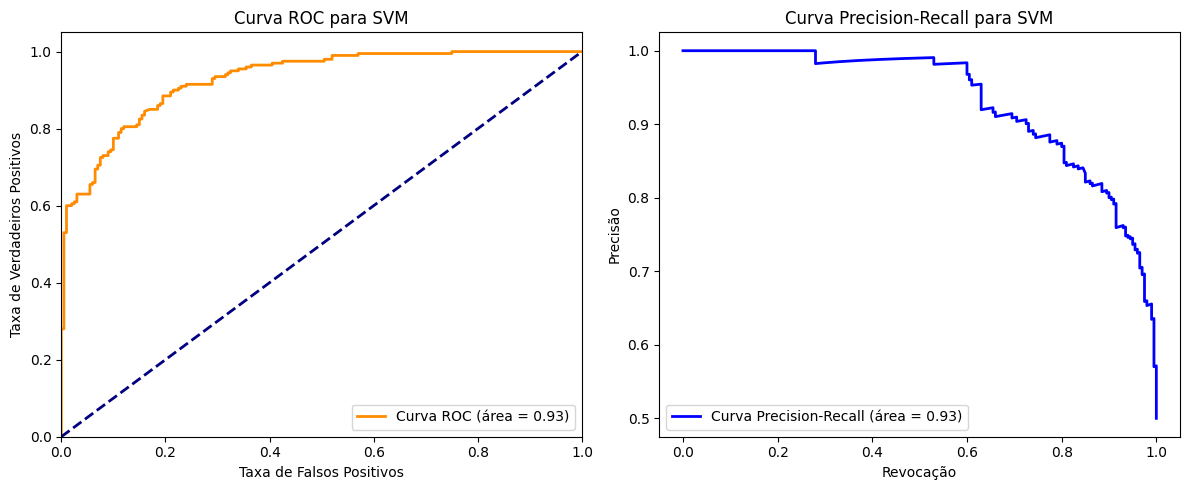

AUROC para SVM: 0.9282
AUPRC para SVM: 0.9328

Treinando e Avaliando Random Forest ---
Iniciando Grid Search com 100 combinações e 10 folds (com normalização manual e KFold manual)...
Testando combinação 1/100: {'random_state': 42, 'n_estimators': np.int64(10), 'max_depth': 4}
   Média de acurácia no CV: 0.8117
Testando combinação 2/100: {'random_state': 42, 'n_estimators': np.int64(10), 'max_depth': 6}
   Média de acurácia no CV: 0.8324
Testando combinação 3/100: {'random_state': 42, 'n_estimators': np.int64(10), 'max_depth': 8}
   Média de acurácia no CV: 0.8405
Testando combinação 4/100: {'random_state': 42, 'n_estimators': np.int64(10), 'max_depth': 10}
   Média de acurácia no CV: 0.8443
Testando combinação 5/100: {'random_state': 42, 'n_estimators': np.int64(10), 'max_depth': None}
   Média de acurácia no CV: 0.8461
Testando combinação 6/100: {'random_state': 42, 'n_estimators': np.int64(20), 'max_depth': 4}
   Média de acurácia no CV: 0.8224
Testando combinação 7/100: {'random_st

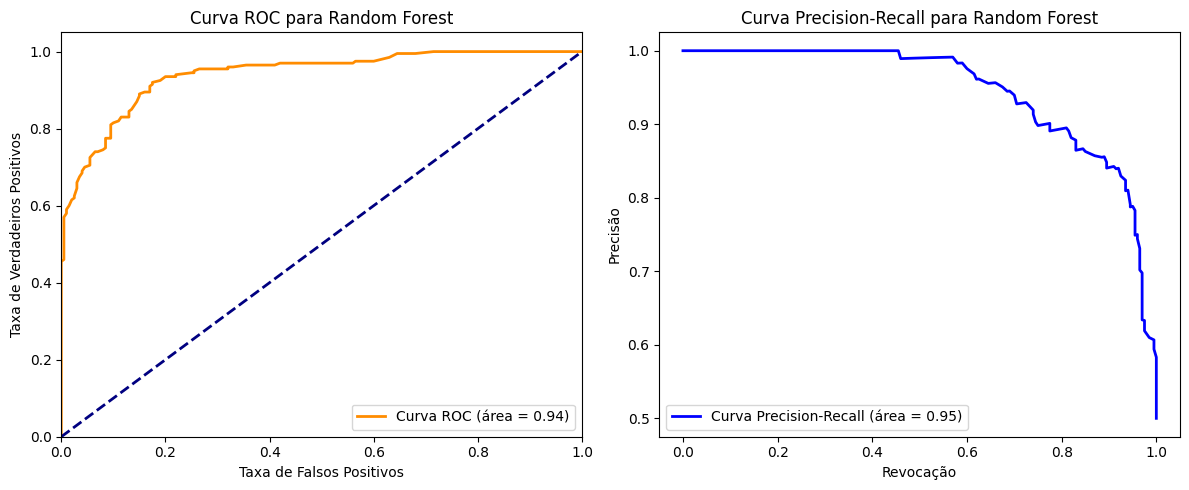

AUROC para Random Forest: 0.9402
AUPRC para Random Forest: 0.9455


In [ ]:
data = pd.read_csv('californiabin.csv')

X = data.iloc[:, :-1]
y = data.iloc[:, -1]


X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dados carregados e divididos com sucesso!")
print(f"Tamanho do conjunto de treinamento (completo para otimização): {len(X_train_full)} amostras")
print(f"Tamanho do conjunto de teste (para avaliação final): {len(X_test_final)} amostras")

def custom_grid_search_cv_manual_kfold(model_class, param_grid, X_train, y_train, n_folds=10, random_state_kf=42):

    best_score = -1
    best_params = {}
    num_samples = len(X_train)
    indices = np.arange(num_samples)

    rng = np.random.default_rng(random_state_kf)
    rng.shuffle(indices)

    fold_sizes = np.full(n_folds, num_samples // n_folds, dtype=int)
    fold_sizes[:num_samples % n_folds] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, end = current, current + fold_size
        folds.append(indices[start:end])
        current = end

    fixed_params = {k: v for k, v in param_grid.items() if not isinstance(v, list)}
    search_params_grid = {k: v for k, v in param_grid.items() if isinstance(v, list)}

    total_combinations = np.prod([len(v) for v in search_params_grid.values()]) if search_params_grid else 1
    current_combination = 0

    print(f"Iniciando Grid Search com {total_combinations} combinações e {n_folds} folds (com normalização manual e KFold manual)...")

    keys = list(search_params_grid.keys())
    values = list(search_params_grid.values())

    for combo in product(*values):
        current_search_params = dict(zip(keys, combo))
        current_params = {**fixed_params, **current_search_params}

        current_combination += 1
        print(f"Testando combinação {current_combination}/{total_combinations}: {current_params}")

        fold_scores = []
        for i in range(n_folds):
            val_indices = folds[i]
            train_indices = np.concatenate([folds[j] for j in range(n_folds) if j != i])

            X_train_fold, X_val_fold = X_train.iloc[train_indices], X_train.iloc[val_indices]
            y_train_fold, y_val_fold = y_train.iloc[train_indices], y_train.iloc[val_indices]

            scaler = StandardScaler()

            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            model = model_class(**current_params)
            model.fit(X_train_fold_scaled, y_train_fold)

            y_pred_val = model.predict(X_val_fold_scaled)
            score = accuracy_score(y_val_fold, y_pred_val)
            fold_scores.append(score)

        mean_score = np.mean(fold_scores)
        print(f"   Média de acurácia no CV: {mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_params = current_params

    return best_params, best_score

#SVM
print("\nTreinando e Avaliando SVM")
param_grid_svm = {
    'kernel': 'rbf',
    'C': [2**i for i in range(-5, 16, 2)],
    'gamma': [2**i for i in range(-15, 4, 2)]
}

start_time_svm = time.time()
best_params_svm, best_score_svm = custom_grid_search_cv_manual_kfold(SVC, param_grid_svm, X_train_full, y_train_full, n_folds=10)
end_time_svm = time.time()

print(f"\nTempo gasto no Grid Search para SVM: {end_time_svm - start_time_svm:.2f} segundos")
print(f"Melhores parâmetros para SVM: {best_params_svm}")
print(f"Melhor pontuação (acurácia média CV) para SVM: {best_score_svm:.4f}")
print("\nRetreinando o modelo SVM final com os melhores hiperparâmetros e normalização...")

final_scaler_svm = StandardScaler()
X_train_full_scaled_svm = final_scaler_svm.fit_transform(X_train_full)

final_svm_model = SVC(**best_params_svm, probability=True)
final_svm_model.fit(X_train_full_scaled_svm, y_train_full)

print("Avaliando o modelo SVM final no conjunto de teste...")
X_test_final_scaled_svm = final_scaler_svm.transform(X_test_final)

y_pred_svm_final = final_svm_model.predict(X_test_final_scaled_svm)
y_proba_svm_final = final_svm_model.predict_proba(X_test_final_scaled_svm)[:, 1]

print("\nRelatório de Classificação para SVM no conjunto de teste final:")
print(classification_report(y_test_final, y_pred_svm_final, labels=[0, 1]))

accuracy_svm = accuracy_score(y_test_final, y_pred_svm_final)
report_svm = classification_report(y_test_final, y_pred_svm_final, output_dict=True, labels=[0, 1])

precision_svm = report_svm.get('1', {}).get('precision', 0.0)
recall_svm = report_svm.get('1', {}).get('recall', 0.0)
f1_svm = report_svm.get('1', {}).get('f1-score', 0.0)

print(f"\nMétricas Resumidas para SVM")
print(f"Acurácia: {accuracy_svm:.4f}")
print(f"Precisão (Classe 1): {precision_svm:.4f}")
print(f"Revocação (Classe 1): {recall_svm:.4f}")
print(f"F1-Score (Classe 1): {f1_svm:.4f}")

fpr_svm, tpr_svm, _ = roc_curve(y_test_final, y_proba_svm_final)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para SVM')
plt.legend(loc="lower right")

precision_svm_pr, recall_svm_pr, _ = precision_recall_curve(y_test_final, y_proba_svm_final)
auprc_svm = average_precision_score(y_test_final, y_proba_svm_final)

plt.subplot(1, 2, 2)
plt.plot(recall_svm_pr, precision_svm_pr, color='blue', lw=2, label=f'Curva Precision-Recall (área = {auprc_svm:.2f})')
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall para SVM')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

print(f"AUROC para SVM: {roc_auc_svm:.4f}")
print(f"AUPRC para SVM: {auprc_svm:.4f}")

print("\nTreinando e Avaliando Random Forest ---")
param_grid_rf = {
    'random_state': 42,
    'n_estimators': list(np.arange(10, 201, 10)),
    'max_depth': [4, 6, 8, 10, None]
}

start_time_rf = time.time()
best_params_rf, best_score_rf = custom_grid_search_cv_manual_kfold(RandomForestClassifier, param_grid_rf, X_train_full, y_train_full, n_folds=10)
end_time_rf = time.time()

print(f"\nTempo gasto no Grid Search para Random Forest: {end_time_rf - start_time_rf:.2f} segundos")
print(f"Melhores parâmetros para Random Forest: {best_params_rf}")
print(f"Melhor pontuação (acurácia média CV) para Random Forest: {best_score_rf:.4f}")

print("\nRetreinando o modelo Random Forest final com os melhores hiperparâmetros e normalização...")

final_scaler_rf = StandardScaler()
X_train_full_scaled_rf = final_scaler_rf.fit_transform(X_train_full)

final_rf_model = RandomForestClassifier(**best_params_rf)
final_rf_model.fit(X_train_full_scaled_rf, y_train_full)

print("Avaliando o modelo Random Forest final no conjunto de teste...")
X_test_final_scaled_rf = final_scaler_rf.transform(X_test_final)

y_pred_rf_final = final_rf_model.predict(X_test_final_scaled_rf)
y_proba_rf_final = final_rf_model.predict_proba(X_test_final_scaled_rf)[:, 1]

print("\nRelatório de Classificação para Random Forest no conjunto de teste final:")
print(classification_report(y_test_final, y_pred_rf_final, labels=[0, 1]))

accuracy_rf = accuracy_score(y_test_final, y_pred_rf_final)
report_rf = classification_report(y_test_final, y_pred_rf_final, output_dict=True, labels=[0, 1])

precision_rf = report_rf.get('1', {}).get('precision', 0.0)
recall_rf = report_rf.get('1', {}).get('recall', 0.0)
f1_rf = report_rf.get('1', {}).get('f1-score', 0.0)

print(f"\nMétricas Resumidas para Random Forest")
print(f"Acurácia: {accuracy_rf:.4f}")
print(f"Precisão (Classe 1): {precision_rf:.4f}")
print(f"Revocação (Classe 1): {recall_rf:.4f}")
print(f"F1-Score (Classe 1): {f1_rf:.4f}")

fpr_rf, tpr_rf, _ = roc_curve(y_test_final, y_proba_rf_final)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Random Forest')
plt.legend(loc="lower right")

precision_rf_pr, recall_rf_pr, _ = precision_recall_curve(y_test_final, y_proba_rf_final)
auprc_rf = average_precision_score(y_test_final, y_proba_rf_final)

plt.subplot(1, 2, 2)
plt.plot(recall_rf_pr, precision_rf_pr, color='blue', lw=2, label=f'Curva Precision-Recall (área = {auprc_rf:.2f})')
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall para Random Forest')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

print(f"AUROC para Random Forest: {roc_auc_rf:.4f}")
print(f"AUPRC para Random Forest: {auprc_rf:.4f}")